In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium 
import plotly.express as px
import datetime
from math import pi

import missingno as msno
from sklearn.impute import KNNImputer
# Autoreg, autocorrolationand time series tools...

from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
#from statsmodels.tsa.ar_model import AutoReg
#from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic


plt.style.use('seaborn-whitegrid')

from termcolor import colored

In [74]:
city_day = pd.read_csv('C:\\Users\\Aditi\\Documents\\Derek\\personal_projects\\Pollution-and-the-Pandemic\\MyProject\\model\\city_day.csv').sort_values(by = ['Date', 'City'])

In [75]:
print(list(city_day.columns))

['City', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket']


In [76]:
city_day.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
4294,Bengaluru,2015-01-01,NaN,NaN,3.26,17.33,10.88,20.36,0.33,3.54,10.73,0.56,4.64,NaN,NaN,NaN
7834,Chennai,2015-01-01,NaN,NaN,16.30,15.39,22.68,4.59,1.17,9.20,11.35,0.17,NaN,NaN,NaN,NaN
10229,Delhi,2015-01-01,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,9.84,472.0,Severe
19846,Lucknow,2015-01-01,NaN,NaN,2.11,13.46,4.57,NaN,12.15,169.57,25.92,1.35,3.93,NaN,NaN,NaN


In [77]:
city_day.describe

<bound method NDFrame.describe of                      City        Date   PM2.5    PM10     NO    NO2     NOx  \
0               Ahmedabad  2015-01-01     NaN     NaN   0.92  18.22   17.15   
4294            Bengaluru  2015-01-01     NaN     NaN   3.26  17.33   10.88   
7834              Chennai  2015-01-01     NaN     NaN  16.30  15.39   22.68   
10229               Delhi  2015-01-01  313.22  607.98  69.16  36.39  110.59   
19846             Lucknow  2015-01-01     NaN     NaN   2.11  13.46    4.57   
...                   ...         ...     ...     ...    ...    ...     ...   
25721               Patna  2020-07-01   35.42   57.82  44.50  31.15   57.72   
26031            Shillong  2020-07-01   16.70   29.40   0.97   2.70    1.04   
26956             Talcher  2020-07-01   24.85   31.06  27.73  29.36   57.09   
28068  Thiruvananthapuram  2020-07-01    2.00   35.00   1.68   2.30    2.58   
29530       Visakhapatnam  2020-07-01   15.00   66.00   0.40  26.85   14.05   

         NH3     

In [78]:
city_day.Date = city_day.Date.apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d'))
city_day = city_day.sort_values(by = 'Date')

In [79]:
print('Date starts from {}, and ends in {}'.format(city_day.Date.min().strftime('%Y-%m-%d'), city_day.Date.max().strftime('%Y-%m-%d')))

Date starts from 2015-01-01, and ends in 2020-07-01


In [80]:
city_day.corr().AQI.sort_values(ascending = False)

AQI        1.000000
PM10       0.803313
CO         0.683346
PM2.5      0.659181
NO2        0.537071
SO2        0.490586
NOx        0.486450
NO         0.452191
Toluene    0.279992
NH3        0.252019
O3         0.198991
Xylene     0.165532
Benzene    0.044407
Name: AQI, dtype: float64

In [81]:
# adding all the features with corr less than 0.4

city_day['B_X_O3_NH3'] = city_day['Benzene'] +\
city_day['Xylene'] + city_day['O3'] + city_day['NH3']

city_day['ParticulateMatters'] = city_day['PM2.5'] + city_day['PM10']

corr_with_AQI = city_day.corr().AQI.sort_values(ascending = False)


corr_with_AQI
# from here we can see: we can impute values with linear
# interpolation for the ones that have high value of corr

AQI                   1.000000
ParticulateMatters    0.823098
PM10                  0.803313
CO                    0.683346
PM2.5                 0.659181
B_X_O3_NH3            0.605700
NO2                   0.537071
SO2                   0.490586
NOx                   0.486450
NO                    0.452191
Toluene               0.279992
NH3                   0.252019
O3                    0.198991
Xylene                0.165532
Benzene               0.044407
Name: AQI, dtype: float64

In [82]:
# how much is the average amount of pollution in each city stations
most_polluted = city_day[['City', 'AQI', 'PM10', 'CO']].groupby(['City']).mean().sort_values(by = 'AQI', ascending = False)
most_polluted

,AQI,PM10,CO
City,,,
Ahmedabad,452.122939,114.584029,22.193407
Delhi,259.487744,232.809229,1.976053
Patna,240.782042,126.747958,1.533591
Gurugram,225.123882,191.504432,1.257516
Lucknow,217.973059,NaN,2.130328
Talcher,172.886819,165.772708,1.847722
Jorapokhar,159.251621,149.657942,0.663049
Brajrajnagar,150.280505,124.217373,1.798274
Kolkata,140.566313,115.629499,0.799251


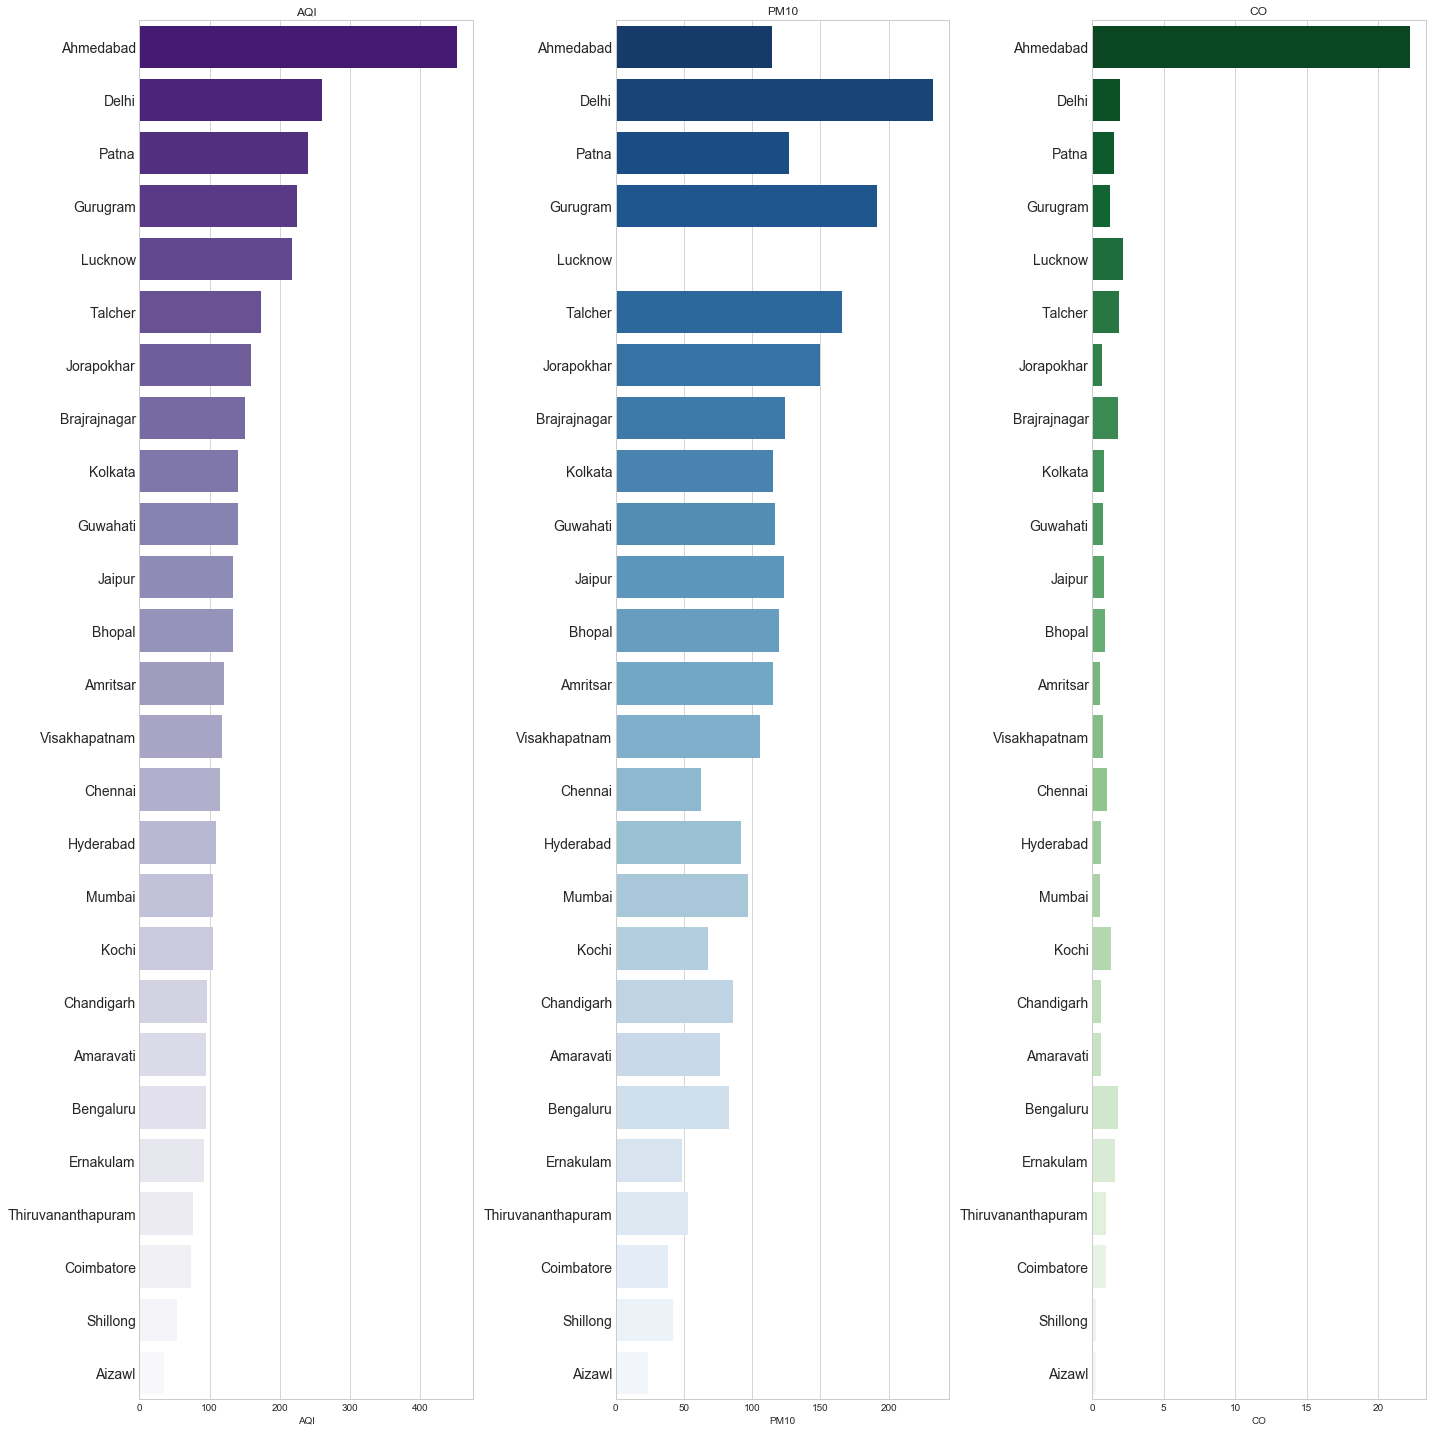

In [83]:
plt.style.use('seaborn-whitegrid')
f, ax_ = plt.subplots(1, 3, figsize = (20,20))

bar1 = sns.barplot(x = most_polluted.AQI,
                   y = most_polluted.index,
                   palette = 'Purples_r',
                   ax = ax_[0]);

bar1 = sns.barplot(x = most_polluted.PM10,
                   y = most_polluted.index,
                   palette = 'Blues_r',
                   ax = ax_[1]);

bar1 = sns.barplot(x = most_polluted.CO,
                   y = most_polluted.index,
                   palette = 'Greens_r',
                   ax = ax_[2]);

titles = ['AQI', 'PM10', 'CO']
for i in range(3) :
    ax_[i].set_ylabel('')   
    ax_[i].set_yticklabels(labels = ax_[i].get_yticklabels(),fontsize = 14);
    ax_[i].set_title(titles[i])
    f.tight_layout()

In [84]:
most_polluted = city_day[['City', 'AQI', 'PM10', 'CO']].groupby(['City']).mean().sort_values(by = 'AQI', ascending = False)

cities = most_polluted.index
params = most_polluted.columns

def first_date(city, parameter):
    df = city_day[(city_day.City == city)]
    df = df[df[parameter].notnull()]
    if len(df) != 0:
        return df.iloc[0].Date.strftime('%Y-%m-%d')
    else: return('no_measurement')
        
        
for city in cities:
    #print(colored('city: ', 'green'), city)
    for param in params:
      #  print('param: ', param)
        most_polluted.loc[city, str(param) + '_date'] = first_date(city, param)
        
most_polluted.head()

,AQI,PM10,CO,AQI_date,PM10_date,CO_date
City,,,,,,
Ahmedabad,452.122939,114.584029,22.193407,2015-01-29,2019-05-14,2015-01-01
Delhi,259.487744,232.809229,1.976053,2015-01-01,2015-01-01,2015-01-01
Patna,240.782042,126.747958,1.533591,2015-10-03,2019-12-24,2015-06-01
Gurugram,225.123882,191.504432,1.257516,2016-01-23,2017-12-31,2015-11-27
Lucknow,217.973059,NaN,2.130328,2015-03-21,no_measurement,2015-01-01


In [85]:
city_day['Year_Month'] = city_day.Date.apply(lambda x : x.strftime('%Y-%m'))

In [86]:
df = city_day.groupby(['Year_Month']).sum().reset_index()

# let's only see those that are important to the AQI
# otherwise we will have a messy plot

metrices = corr_with_AQI[corr_with_AQI>0.5].index

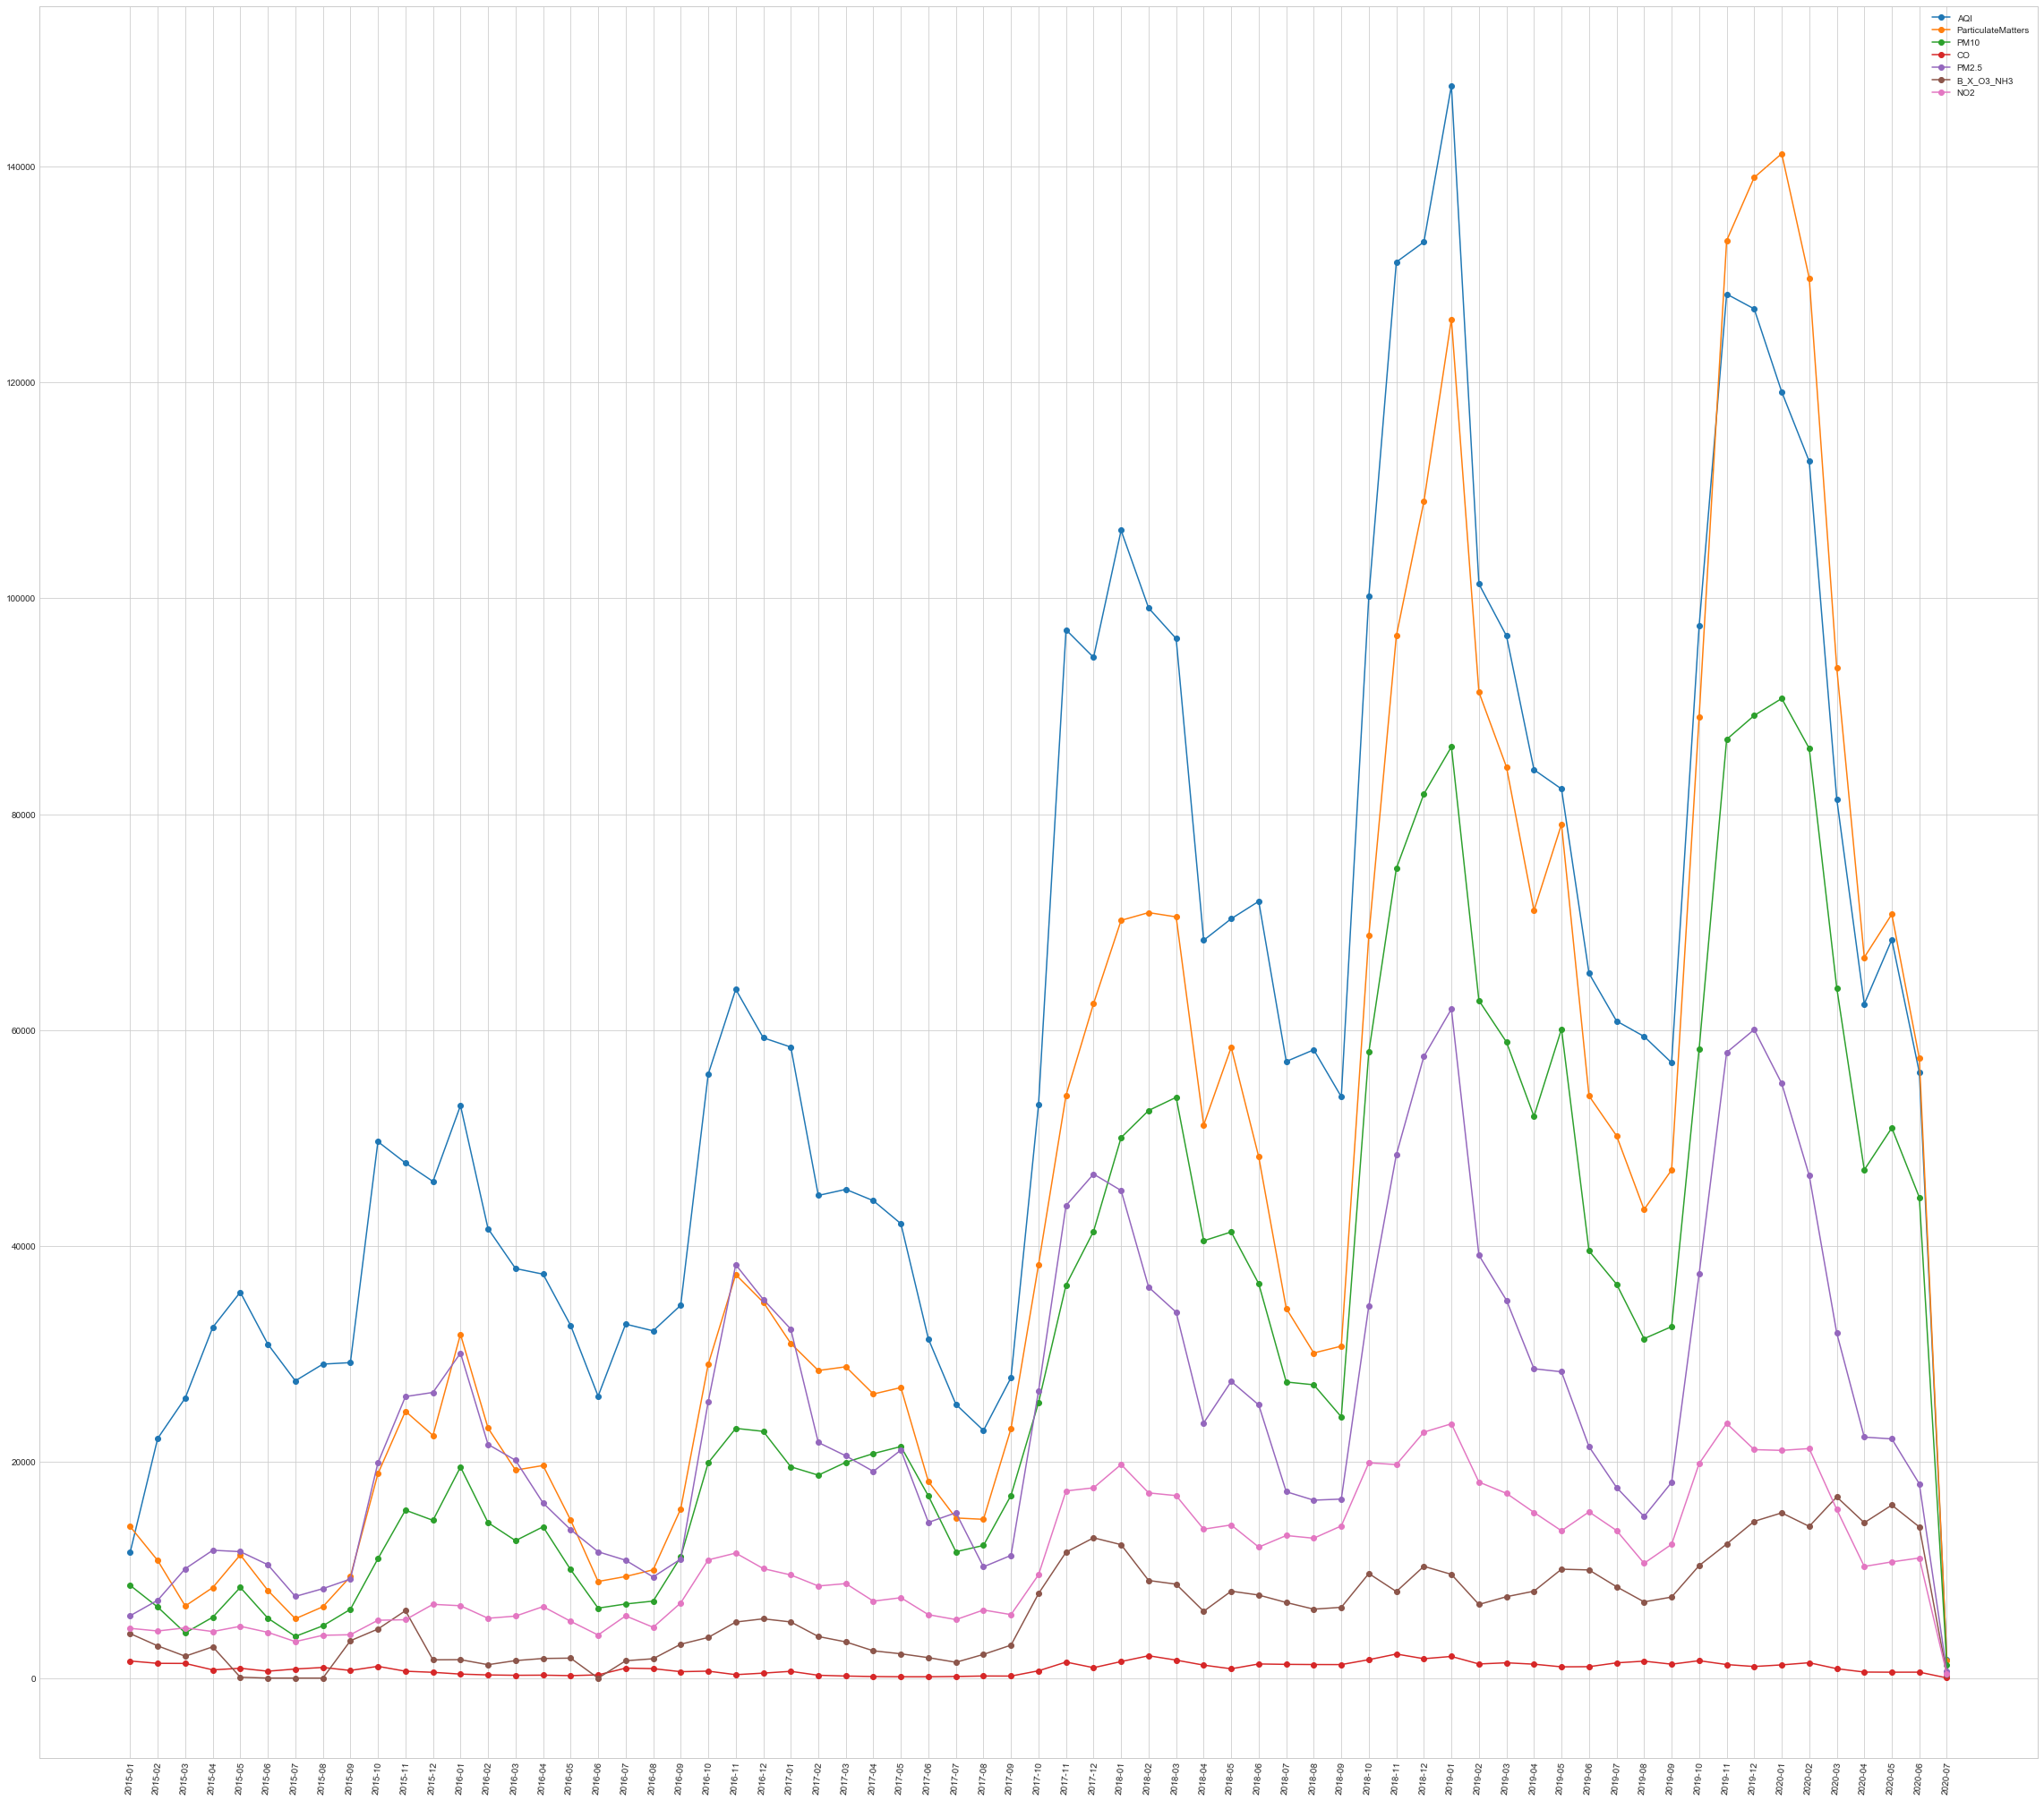

In [87]:
plt.style.use('seaborn-whitegrid');
fig, ax_ = plt.subplots(figsize=(40,36));

df = city_day.groupby(['Year_Month']).sum().reset_index()

for col in metrices:
    x = df['Year_Month']
    y = df[col]
    
    ax_.plot_date(x ,y ,label=col, linestyle="-");
    
ax_.set_xticklabels(df['Year_Month'], rotation=85);
ax_.legend();

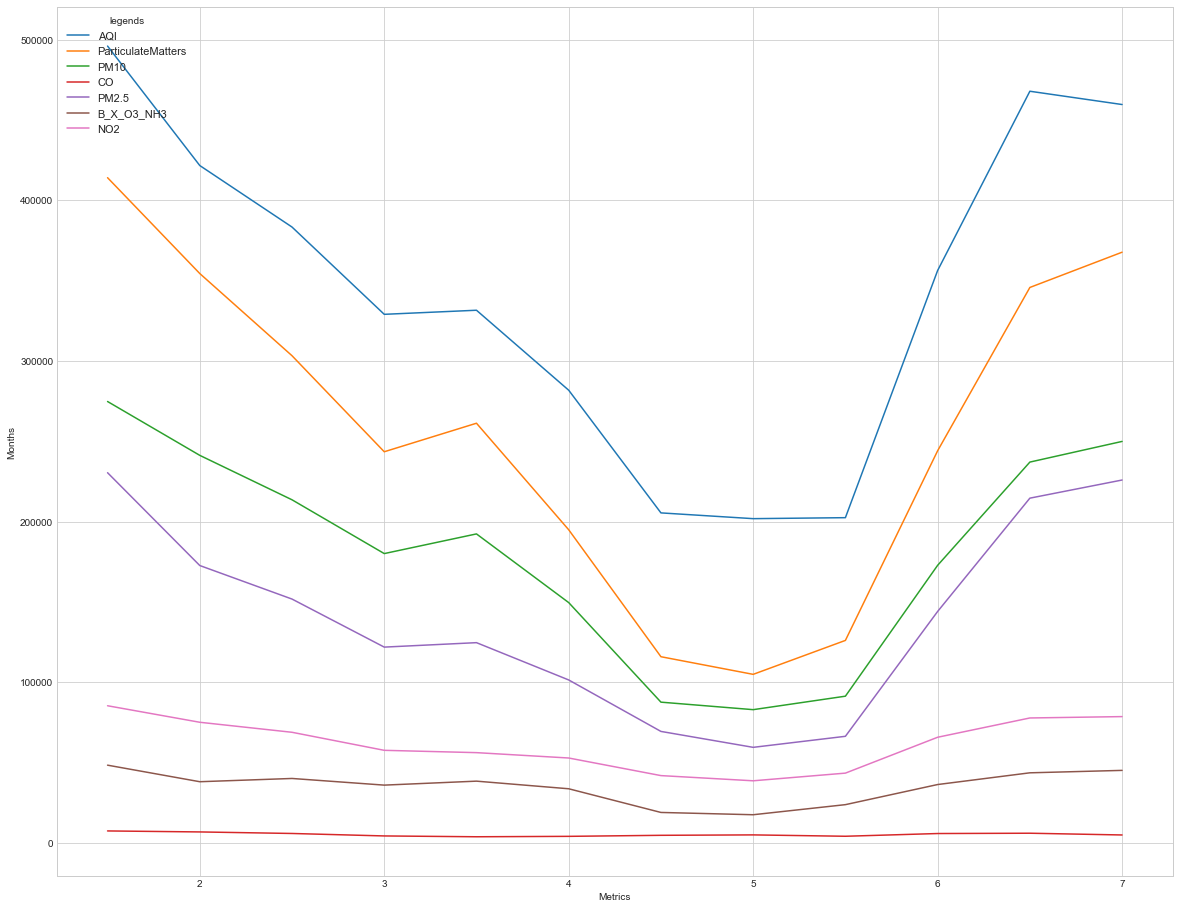

In [88]:
city_day['Month'] = city_day.Date.dt.month
city_day['Year'] = city_day.Date.dt.year
index = 'Month'
df = city_day.groupby([index]).sum().reset_index()

plt.style.use('seaborn-whitegrid');
fig, ax_ = plt.subplots(figsize=(20,16));



for i, col in enumerate(metrices):
    x = df[index]
    y = df[col]
    #print(y)
    plot = sns.lineplot(x ,y );
    

plot.set_xticklabels(df[index], );
ax_.set(xlabel='Metrics', ylabel='Months');
leg = plot.legend(title='legends', loc='upper left', labels=metrices, fontsize = 11);

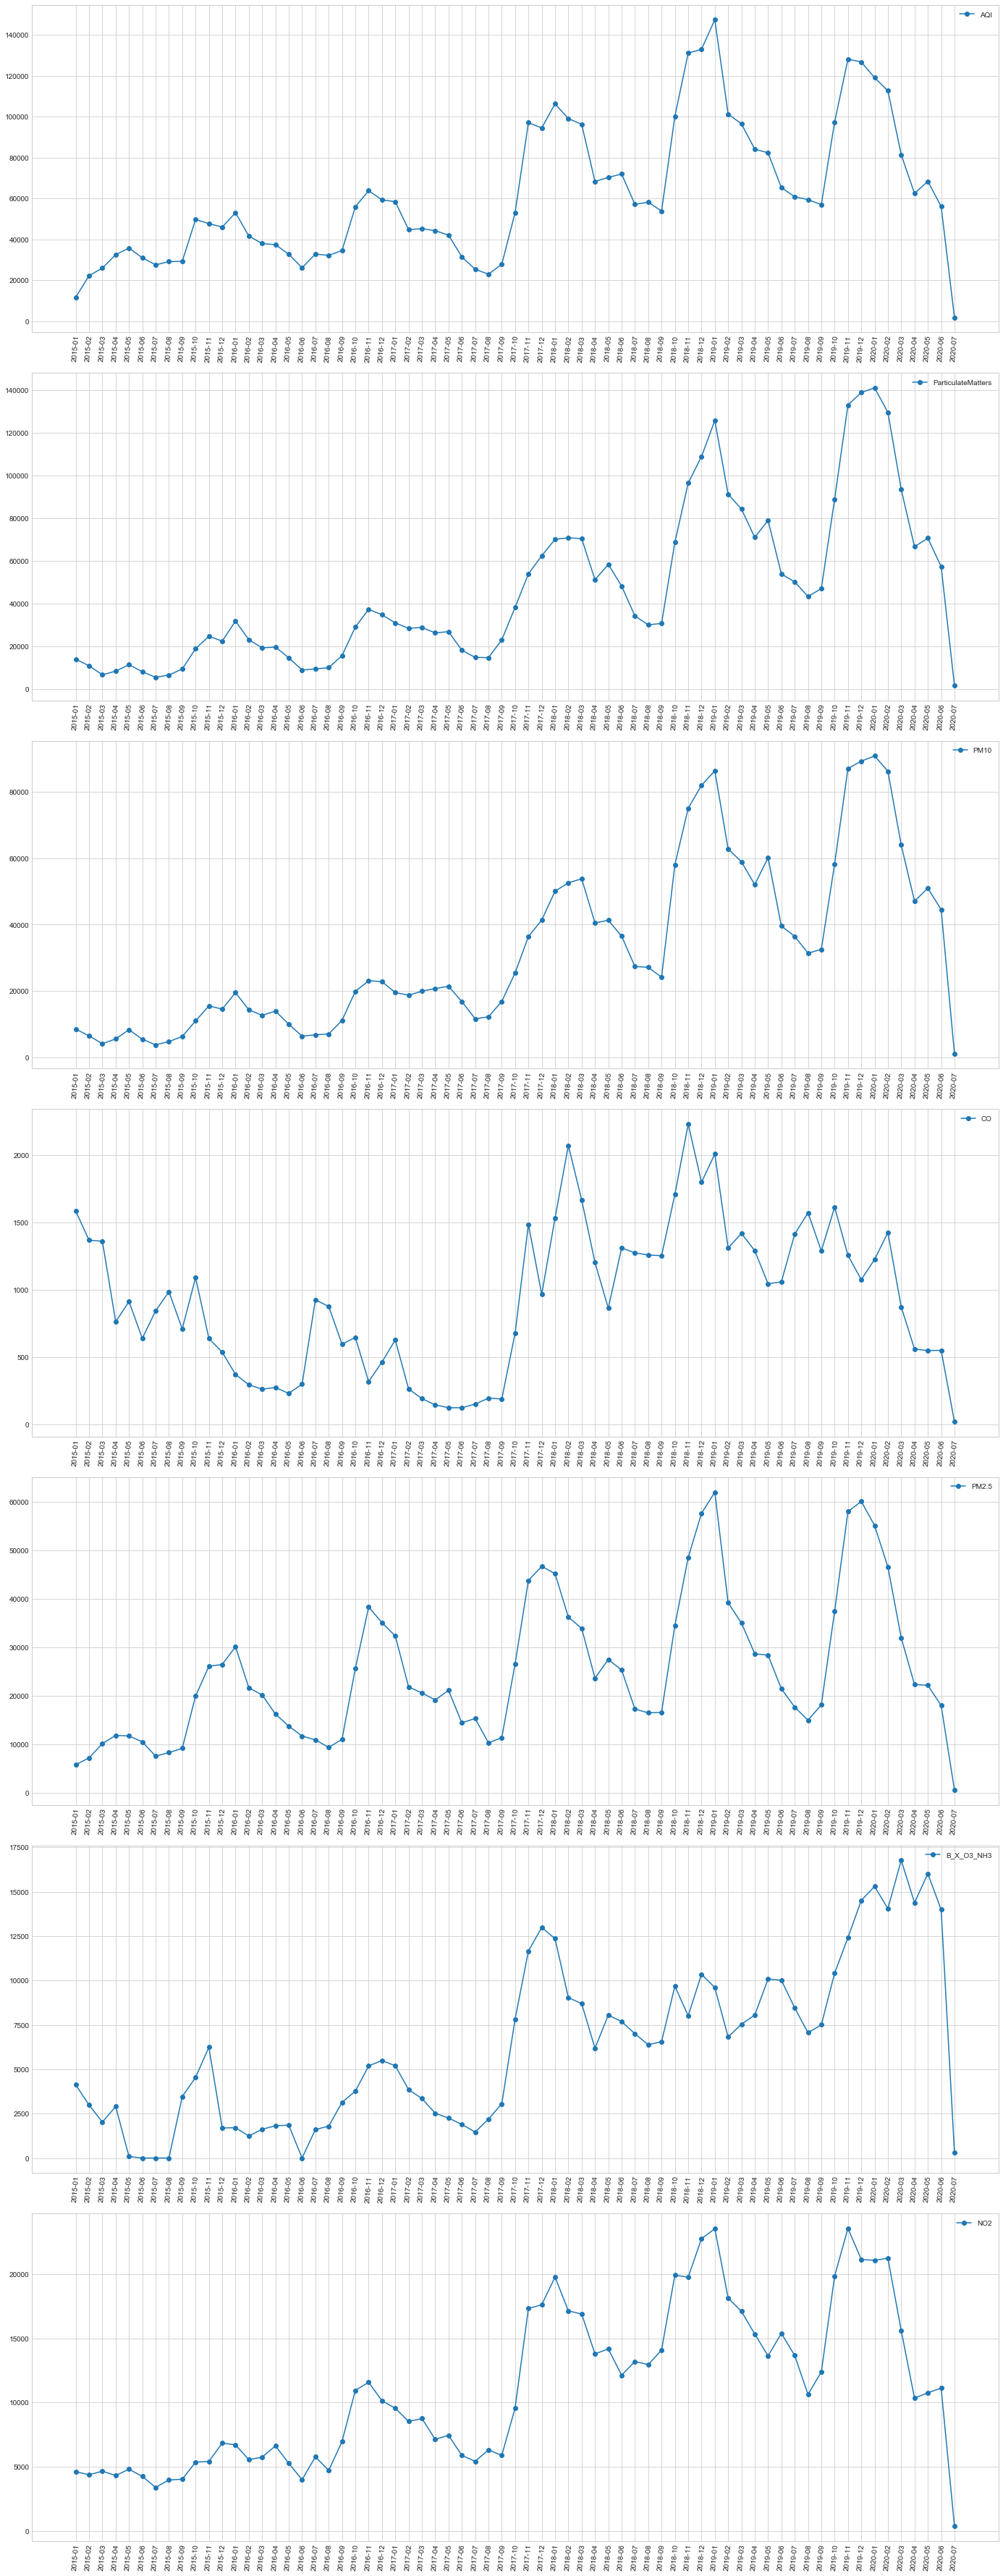

In [89]:
df = city_day.groupby(['Year_Month']).sum().reset_index()

plt.style.use('seaborn-whitegrid')
fig, ax_ = plt.subplots(len(metrices), 1, figsize=(20,50))

fig.tight_layout(pad=4)
for i, col in enumerate(metrices):
    
    x = df['Year_Month']
    y = df[col]
    ax_[i].plot_date(x ,y ,label=col, linestyle="-")
    ax_[i].set_xticklabels(df['Year_Month'], rotation=85);
    ax_[i].legend();

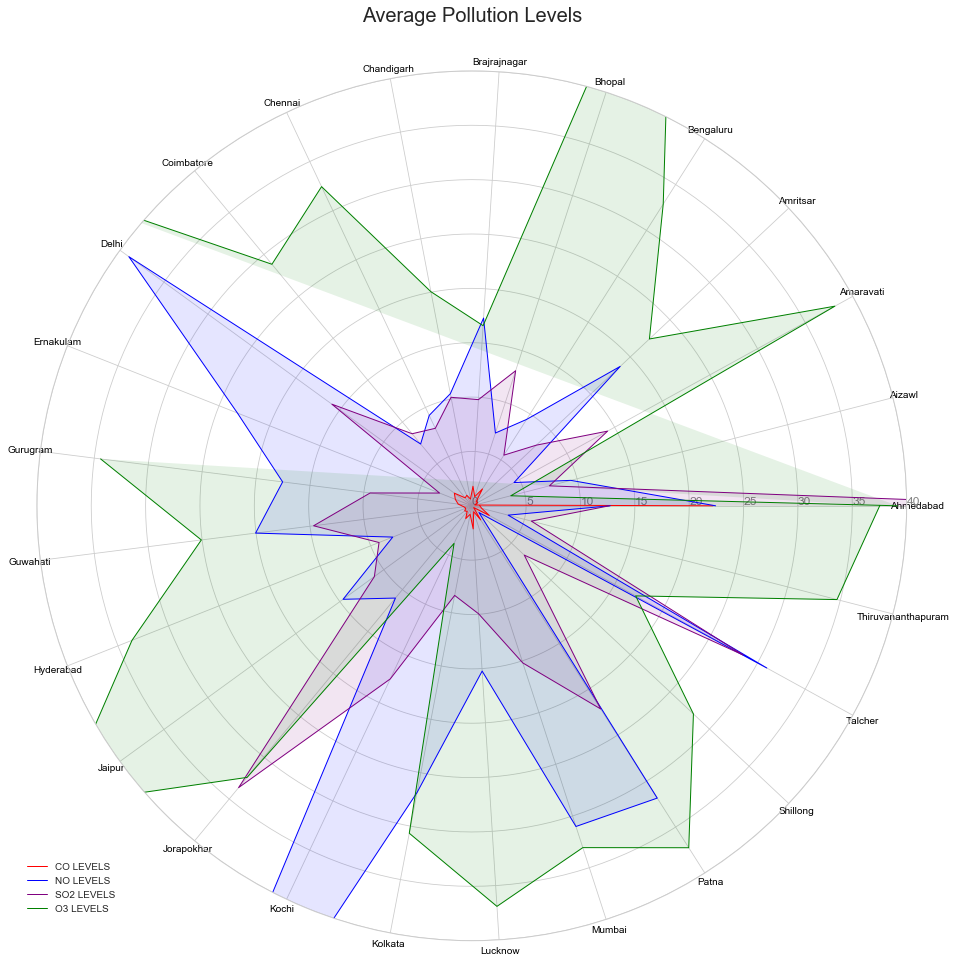

In [90]:
df_CO = city_day.pivot(index='Date', columns='City', values='CO')
df_CO = df_CO.fillna(df_CO.mean())

df_NO = city_day.pivot(index='Date', columns='City', values='NO')
df_NO = df_NO.fillna(df_NO.mean())

df_SO2 = city_day.pivot(index='Date', columns='City', values='SO2')
df_SO2 = df_SO2.fillna(df_SO2.mean())

df_O3 = city_day.pivot(index='Date', columns='City', values='O3')
df_O3 = df_O3.fillna(df_O3.mean())

categories=list(df_CO)[0:]
N = len(categories)

values_co  = df_CO.mean(axis=0)
values_no  = df_NO.mean(axis=0)
values_so2 = df_SO2.mean(axis=0)
values_o3  = df_O3.mean(axis=0)

angles = [n / float(N-1) * 2 * pi for n in range(N-1)]
angles += angles[:1]

 
fig = plt.figure(figsize=(20,16))
ax = plt.subplot(111, polar=True)
 
plt.xticks(angles[:-1], categories, color='black', size=10)
 
ax.set_rlabel_position(0)
plt.yticks([0,5,10,15,20,25,30,35,40], ["0","5","10","15","20","25","30","35","40"], color="grey", size=12)
plt.ylim(0,40)
 
ax.plot(angles, values_co, 'red',linewidth=1, linestyle='solid', label="CO LEVELS")
ax.fill(angles, values_co, 'red', alpha=0.1)

ax.plot(angles, values_no, 'blue',linewidth=1, linestyle='solid', label="NO LEVELS")
ax.fill(angles, values_no, 'blue', alpha=0.1)

ax.plot(angles, values_so2,'purple',linewidth=1, linestyle='solid', label="SO2 LEVELS")
ax.fill(angles, values_so2,'purple', alpha=0.1)

ax.plot(angles, values_o3, 'green',linewidth=1, linestyle='solid', label="O3 LEVELS")
ax.fill(angles, values_o3, 'green', alpha=0.1)

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title("Average Pollution Levels",fontsize=20);

In [91]:
def tell_me_null(df):
    num_null = df.isnull().sum().sort_values(ascending = False)
    percentage_null = round(df.isnull().sum().sort_values(ascending = False)/len(df) * 100, 1)
    return pd.DataFrame(np.c_[num_null, percentage_null], index = num_null.index,  columns = ['# of Null', 'Percentage'])

In [92]:
tell_me_null(city_day)

,# of Null,Percentage
B_X_O3_NH3,22788.0,77.2
Xylene,18109.0,61.3
ParticulateMatters,11899.0,40.3
PM10,11140.0,37.7
NH3,10328.0,35.0
Toluene,8041.0,27.2
Benzene,5623.0,19.0
AQI_Bucket,4681.0,15.9
AQI,4681.0,15.9
PM2.5,4598.0,15.6


In [93]:
delhi = city_day[(city_day.AQI.notnull()) & (city_day.City == 'Delhi')]

In [94]:
tell_me_null(delhi)

,# of Null,Percentage
B_X_O3_NH3,772.0,38.6
Xylene,771.0,38.6
SO2,102.0,5.1
O3,76.0,3.8
PM10,69.0,3.5
ParticulateMatters,69.0,3.5
NH3,8.0,0.4
PM2.5,1.0,0.1
NO,1.0,0.1
NO2,1.0,0.1


In [95]:
corr = delhi.corr().AQI.sort_values(ascending = False)
related = list(corr[corr>0.6].index)
print(related)
inter = delhi.loc[:, related].interpolate(method = 'linear');
delhi.loc[:, related] = inter

['AQI', 'ParticulateMatters', 'PM10', 'PM2.5', 'Benzene', 'NO2', 'NO', 'B_X_O3_NH3']


C:\Users\Aditi\anaconda3\lib\site-packages\pandas\core\indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [96]:
knn_imputer = KNNImputer(n_neighbors = 3)

imputing_cols = [ 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2',
       'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'B_X_O3_NH3',
       'ParticulateMatters', 'Month', 'Year']
# we eliminated city, date, Year_Month and AQI_Bucket because 
# they either were unique or had numerical substitude in other fields(AQI_bucket)

knn_imputer.fit(delhi[imputing_cols])

imputed = knn_imputer.transform(delhi[imputing_cols])

delhi.loc[:, imputing_cols] = imputed

C:\Users\Aditi\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [97]:
tell_me_null(delhi)

,# of Null,Percentage
City,0.0,0.0
Benzene,0.0,0.0
Month,0.0,0.0
Year_Month,0.0,0.0
ParticulateMatters,0.0,0.0
B_X_O3_NH3,0.0,0.0
AQI_Bucket,0.0,0.0
AQI,0.0,0.0
Xylene,0.0,0.0
Toluene,0.0,0.0


### Model:

In [98]:
#%matplotlib inline
#from forecast import utils

In [99]:
delhi_aqi = delhi[['Date','AQI']]

In [100]:
print(delhi_aqi)

            Date    AQI
10229 2015-01-01  472.0
10230 2015-01-02  454.0
10231 2015-01-03  143.0
10232 2015-01-04  319.0
10233 2015-01-05  325.0
...          ...    ...
12233 2020-06-27  112.0
12234 2020-06-28  196.0
12235 2020-06-29  233.0
12236 2020-06-30  114.0
12237 2020-07-01  101.0

[1999 rows x 2 columns]


In [101]:
delhi_aqi.reset_index(inplace = True,drop = True)

train_df = delhi_aqi
train_df.rename(mapper = {'Date':'ds','AQI':'y'},axis =1,inplace = True)
train_df


C:\Users\Aditi\anaconda3\lib\site-packages\pandas\core\frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,ds,y
0,2015-01-01,472.0
1,2015-01-02,454.0
2,2015-01-03,143.0
3,2015-01-04,319.0
4,2015-01-05,325.0
...,...,...
1994,2020-06-27,112.0
1995,2020-06-28,196.0
1996,2020-06-29,233.0
1997,2020-06-30,114.0


In [102]:
#!pip install forecast_x

In [103]:
from forecast_x import forecast_x as fx
a = list(train_df['y'])
freq = 3
period_ahead = 12

In [104]:
model = fx.forecast(a, freq, period_ahead)
naive = model.model_naive()
best_model = model.best_model()
best_model

'model_seas_double_mean_growth'

In [105]:
model.optimizer()['model_seas_double_mean_growth']

[123.06322787823075,
 146.63905687689697,
 214.0643495111544,
 120.57823466344061,
 121.42951166262085]

In [111]:
fcst = get_forecast(model)
print(fcst)

NameError: name 'get_forecast' is not defined

# Next part


In [106]:
import matplotlib.pyplot as plt
plt.plot(fcst)


NameError: name 'fcst' is not defined

In [39]:
#!pip install fbprophet

In [40]:
mod_2 = train_df
mod_2["ds"] = pd.to_datetime(mod_2["ds"])
mod_2 = mod_2.set_index('ds')
#mod_2.index = mod_2['ds']
#mod_2.drop(columns = ['ds'],inplace = True)
mod_2

C:\Users\Aditi\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,y
ds,
2015-01-01,472.0
2015-01-02,454.0
2015-01-03,143.0
2015-01-04,319.0
2015-01-05,325.0
...,...
2020-06-27,112.0
2020-06-28,196.0
2020-06-29,233.0


In [41]:
x = mod_2.values
train_size = int(len(x) * 0.66)
train,test = mod_2[0:train_size], mod_2[train_size:len(x)]
print("Total observation:",len(x))
print("Train observation:",len(train))
print("Test observation:",len(test))
mod_2 = train

Total observation: 1999
Train observation: 1319
Test observation: 680


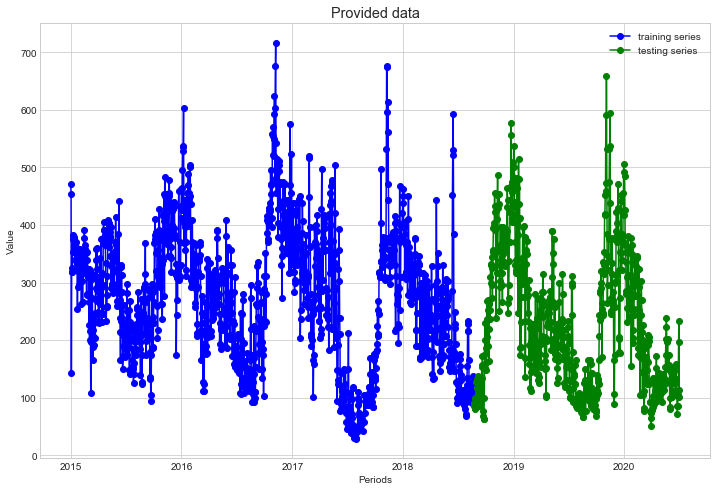

In [42]:
fig = plt.figure(figsize=(12,8))
plt.plot(mod_2.index,mod_2,c="blue",marker="o",label = "training series")
plt.plot(test.index,test,"g-o",label = "testing series")
plt.style.use("ggplot")
plt.title("Provided data")
plt.xlabel("Periods")
plt.ylabel("Value")
plt.legend()
plt.show()

NameError: name 'naive_prediction' is not defined

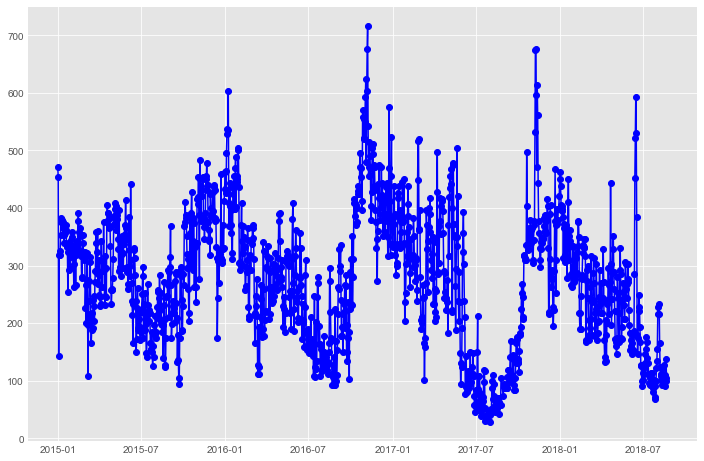

In [43]:

from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 12,8

plt.plot(mod_2.index,mod_2,"b-o",label="original")
plt.plot(naive_prediction.index,naive_prediction,"g--",marker="*",label = "naive prediction")
plt.title("Naive Prediction")
plt.xlabel("Periods")
plt.ylabel("Value")
plt.legend()
plt.show()


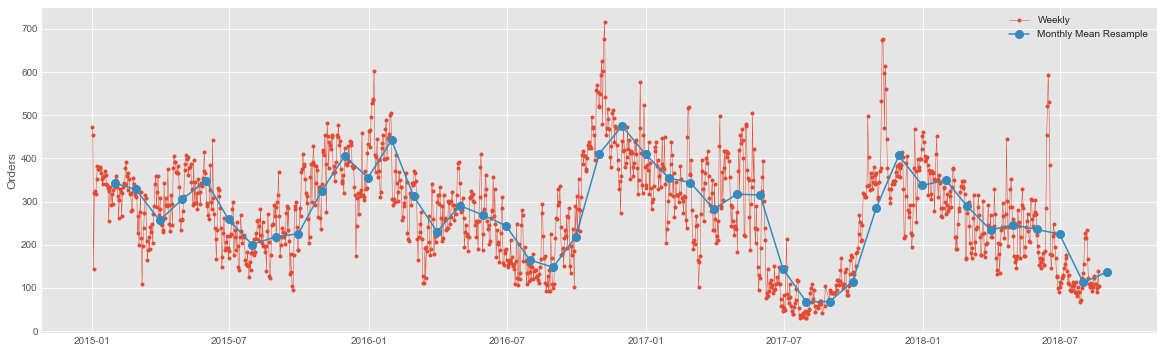

In [44]:
import warnings
import matplotlib.pyplot as plt
y = mod_2['y']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Orders')
ax.legend();

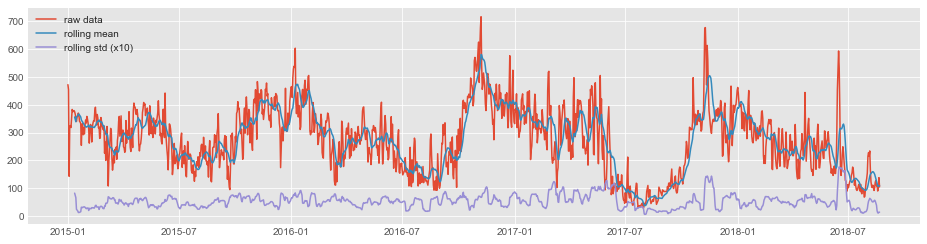

In [45]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')


In [143]:
#holt model

In [46]:
from statsmodels.tsa.api import ExponentialSmoothing

def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):
    
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)
    
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit(use_boxcox=True)
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()

In [47]:
y_to_train = mod_2 # dataset to train
y_to_train.dropna(inplace = True)
y_to_val = test # last X months for test  
y_to_val.dropna(inplace = True)
predict_date = len(mod_2["y"]) - len(y_to_val)
y = train_df["y"].dropna()

holt_win_sea(y, y_to_train,y_to_val,'additive',52, predict_date)

C:\Users\Aditi\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Aditi\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Aditi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Aditi\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: Converge

The Root Mean Squared Error of additive trend, additive seasonal of period season_length=52 and a Box-Cox transformation y      NaN
1319   NaN
1320   NaN
1321   NaN
1322   NaN
        ..
1953   NaN
1954   NaN
1955   NaN
1956   NaN
1957   NaN
Length: 640, dtype: float64


C:\Users\Aditi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Aditi\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Users\Aditi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


The Root Mean Squared Error of additive damped trend, additive seasonal of period season_length=52 and a Box-Cox transformation y      NaN
1319   NaN
1320   NaN
1321   NaN
1322   NaN
        ..
1953   NaN
1954   NaN
1955   NaN
1956   NaN
1957   NaN
Length: 640, dtype: float64


ValueError: view limit minimum -36846.35 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36846.35 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 1008x504 with 1 Axes>